### 6. Apply a (running) average 3x3 numerical filter to both channel-1 and channel-2 images using a zero-padding technique and then display smoothed images comparing them with the original ones.


In [0]:
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.metrics import cohen_kappa_score
from sklearn.linear_model import LinearRegression
#import seaborn as sb
from matplotlib.pyplot import imshow
import pprint as pp
from collections import defaultdict
from sklearn.metrics import confusion_matrix,cohen_kappa_score,precision_score
from sklearn.preprocessing import StandardScaler

In [0]:
def return_image(filename):
    result = list()
    file = open(filename, 'r', )
    lines = file.readlines()
    for x in lines:
        result.append([measure.strip() for measure in x.split('\t')[:-1]])
    
    return(np.asarray(result,dtype=np.float32))

In [0]:
CH1 = return_image("Image_ch1_spectralRadiance.dat")
CH2 = return_image("Image_ch2_spectralReflectance.dat")

In [0]:
def smoothing_image(array):

    # padding the array with 0 values margins
    ar_pad = np.pad(array, [(1, 1), (1, 1)], mode='constant', constant_values=0)
    #defining the kernel 3x3 running window
    kernel = np.ones((3,3),np.float32)/9   
    # filtering
    sm_img = cv2.filter2D(ar_pad,-1,kernel)[1:-1,1:-1]  
    # [1:-1,1:-1]  to slice the matrix in order to un-pad the array
    return(sm_img)

In [0]:
def plot_images(array,sm_img,channel_number):
        fig = plt.figure(figsize=(18,6))
    
        ax1 = fig.add_subplot(121) # original image
        ax2 = fig.add_subplot(122) # smoothed image
        
        ax1 = sns.heatmap(array, cmap= 'jet', annot=False,cbar=True,ax=ax1) 
        ax2 = sns.heatmap(sm_img, cmap= 'jet', annot=False,cbar=True,ax=ax2)
                
        for ax in [ax1,ax2]:
            ax.set(xlabel='x coordinate') 
            ax.set(ylabel='y coordinate') 
            ax.xaxis.label.set_size(20) 
            ax.yaxis.label.set_size(20) 
        
        ax1.set_title('Original input CH'+str(channel_number), color='black', fontsize=30,pad=15)
        ax2.set_title('Smoothed input CH'+str(channel_number), color='black', fontsize=30,pad=15) 
        
        plt.show()

In [0]:
CH1_smoothed = smoothing_image(CH1)
CH2_smoothed = smoothing_image(CH2)

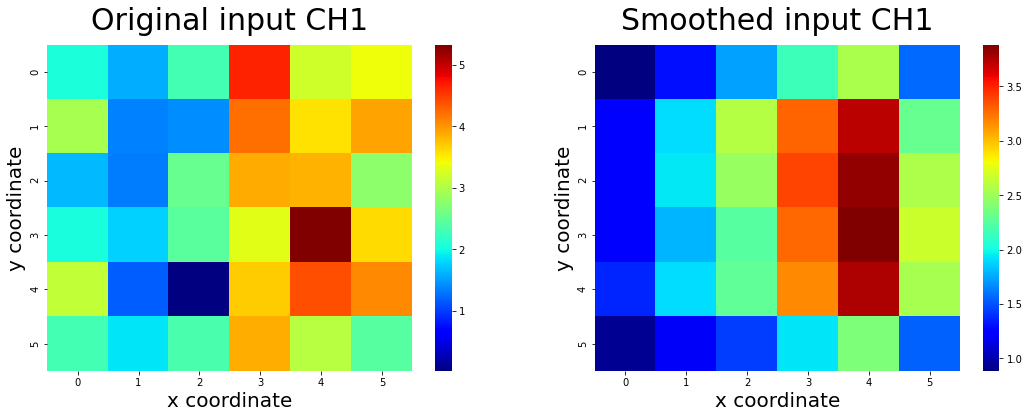

In [29]:
plot_images(CH1,CH1_smoothed,1)

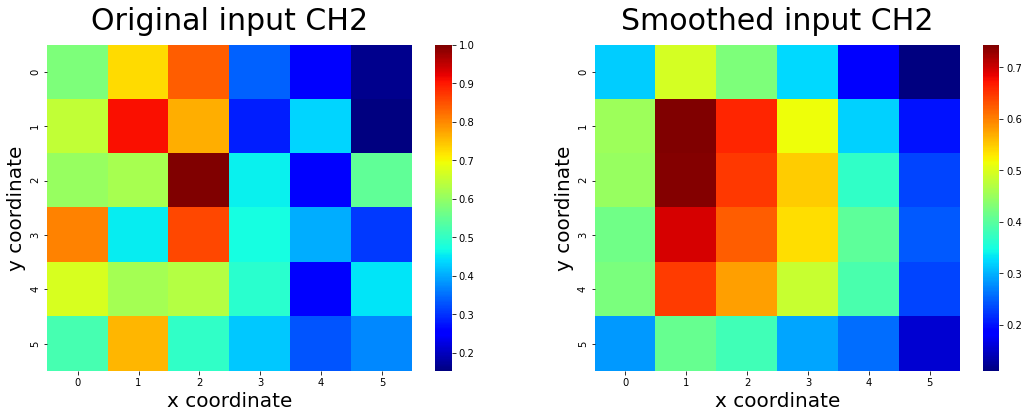

In [30]:
plot_images(CH2,CH2_smoothed,2)

In [32]:
doc_files = ["Image_ch1_spectralRadiance.dat",
             "Image_ch2_spectralReflectance.dat",
             "Image_class_insituLabels.dat",
             "Image_parameter_insituMeasurements.dat"]

doc_names = ["Spectral_Radiance",
             "Spectral_Reflectance",
             "class",
             "Temperature [K]"]

def import_files(files,file_names):
    results = dict() # dict where to store all the files
    for e,files in enumerate(files):
        result = list()
        file = open(files, 'r', ) # open the file
        lines = file.readlines()
        for x in lines:
            result.append([float(measure.strip()) for measure in x.split('\t')[:-1]])

        results[file_names[e]] = [v for r in result for v in r] #unpack the list of lists
            
        if file_names[e] == 'class':
            results['Class_label'] = ['sea surface' if int(value)==2 
              else'cloud particles'
                 for value in results['class']] # add class label
    file.close()
    return results

dictionary = import_files(doc_files,doc_names)
df_images = pd.DataFrame.from_dict(dictionary)
df_images.head()

,Spectral_Radiance,Spectral_Reflectance,class,Class_label,Temperature [K]
0,2.068526,0.579204,1.0,cloud particles,277.39425
1,1.588779,0.725697,1.0,cloud particles,266.11364
2,2.308740,0.838262,1.0,cloud particles,277.84215
3,4.651697,0.338762,2.0,sea surface,297.25935
4,3.197330,0.246227,2.0,sea surface,282.75330


7. By using the smoothed channel images, re-perform a Lloyd’s k-means unsupervised
classification and then compute the confusion matrix (CM) and Cohen’s index kappa.

In [0]:
smooted = {'CH1_smooted':[v for r in CH1_smooted.tolist() for v in r], 
           'CH2_smooted':[v for r in CH2_smooted.tolist() for v in r]}
df_smooted = pd.concat([pd.DataFrame.from_dict(smooted), df_images.iloc[:,2:]], axis=1)
del smooted

In [34]:
df_smooted.head()

,CH1_smooted,CH2_smooted,class,Class_label,Temperature [K]
0,0.885186,0.317779,1.0,cloud particles,277.39425
1,1.300592,0.496267,1.0,cloud particles,266.11364
2,1.729151,0.429425,1.0,cloud particles,277.84215
3,2.154620,0.323555,2.0,sea surface,297.25935
4,2.556010,0.180335,2.0,sea surface,282.75330


In [0]:
def k_mean_and_cm(df):
    
    kmeans = KMeans(n_clusters=2,
                    init="random",
                    n_init=10,
                    max_iter = 20,
                    random_state=10,
                    n_jobs=-1, 
                    algorithm='full') 
    
    kmeans.fit(df.iloc[:,:2]) 
    

    predicted_label = ['sea surface' if value== 0.
                       else'particle clouds'
                       for value in kmeans.labels_.astype(float)] 
    
    df['predicted_label'] = predicted_label 
    
    
    true = df['Class_label'] 
    pred = df['predicted_label'] 
    cm = confusion_matrix(true,pred) 
    
    return(df,cm)

In [0]:
df_smooted, cm_smooted = k_mean_and_cm(df_smooted)

In [0]:
def confusion_matrix_plot(cm):

    fig = plt.figure(figsize=(7,5))
    ax = sns.heatmap(cm, cmap= 'Pastel1', annot=True,annot_kws={"size": 20},cbar=False)
    ax.set_xticklabels(['sea surface','particle clouds'],size=15)
    ax.set_yticklabels(['sea surface','particle clouds'],va='center',size=15)

    ax.set(xlabel='Real class')
    ax.set(ylabel='Predicted')
    ax.yaxis.label.set_size(20)
    ax.xaxis.label.set_size(20)
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    ax.yaxis.labelpad = 20
    ax.xaxis.labelpad = 20
    plt.show()



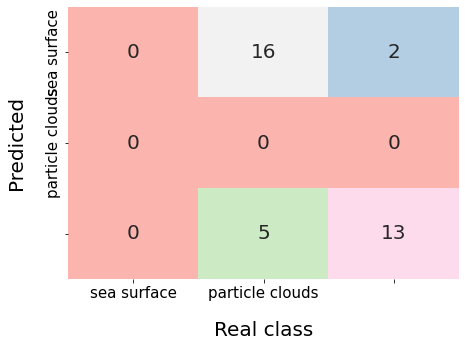

In [51]:
confusion_matrix_plot(cm_smooted)

8. By using the collocated channel and parameter data, develop a statistical retrieval algorithm
(e.g., linear regression) to estimate parameter value from spectral radiance (channel 1) and
provide error bias (mean) and standard deviation in kelvins.

In [52]:
x = df_images.iloc[:,:1]
y = df_images.iloc[:,2]

linearregression = LinearRegression()
linearregression.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [53]:
linearregression.coef_

array([0.35011448])

In [54]:
linearregression.intercept_

0.5108953508346579

In [0]:
ypred = linearregression.predict(df_images.iloc[:,:1])

In [56]:
errors = list()
for e,v in enumerate(list(ypred)):
    errors.append(abs(v - y.tolist()[e])) # append absolute error to errors list
error = np.mean(errors) # compute mean absolute error
std = np.sqrt(np.mean([z**2 for z in errors]) - error**2) # compute std
print('error: '+str(round(error,2))+' K',
     '\u03C3: '+str(round(std,2))+' K',
     sep='\n')

error: 0.24 K
σ: 0.17 K
